# BAYES Project - Leuk: Cox regression
*JAUD Stephen* \
*SURABHI Saimourya* \
*Caillat Maéva*


## Data and context

Several authors have discussed Bayesian inference for censored survival data where the integrated baseline hazard function is to be estimated non-parametrically Kalbfleisch (1978), Kalbfleisch and Prentice (1980), Clayton (1991), Clayton (1994). Clayton (1994) formulates the Cox model using the counting process notation introduced by Andersen and Gill (1982) and discusses estimation of the baseline hazard and regression parameters using MCMC methods. We show below how to implement this formulation of the Cox model.

For subjects $i = 1...n$, we observe processes $N_i(t)$ which count the number of failures which have occurred up to time $t$. The corresponding intensity process $I_i(t)$ is given by:
\begin{equation}
    I_i(t) dt = \mathbb{E} \left( dN_i(t) \, | \,\, F_{t-} \right)
\end{equation}

where $dN_i(t)$ is the increment of $N_i$ over the small time interval $[t, t+dt[$, and $F_{t-}$ represents the available data just before time $t$. If subject $i$ is observed to fail during this time interval, $dN_i(t)$ will take the value 1; otherwise $dN_i(t) = 0$. Hence $\mathbb{E} \left( dN_i(t) \, | \,\, F_{t-} \right)$ corresponds to the probability of subject $i$ failing in the interval $[t, t+dt[$. As $dt \to 0$ (assuming time to be continuous) then this probability becomes the instantaneous hazard at time $t$ for subject $i$ . This is assumed to have the proportional hazards form:  
\begin{equation}
    I_i(t) = Y_i(t) \, \lambda_0(t) \, e^{\beta z_i}
\end{equation}

where $Y_i(t)$ is an observed process taking the value 1 or 0 according to whether or not subject $i$ is observed at time $t$ and $\lambda_0(t)e^{\beta z_i}$ is the familiar Cox regression model. Thus we have observed data $D = \left(N_i(t), \, Y_i(t), \, z_i\right)_{1...n}$ and unknown parameters $\beta$ and $\Lambda_0(t) = \int_0^t \lambda_0(u) du$, the latter to be estimated non-parametrically.

The joint posterior distribution for the above model is defined by
\begin{equation}
    \mathbb{P}\left( \beta, \Lambda_0(.) \, | \,\, D \right) \propto
    \mathbb{P}\left( D \, | \,\, \beta, \Lambda_0(.) \right) \mathbb{P}(\beta) \mathbb{P}\left(\Lambda_0(.)\right)
\end{equation}

Under non-informative censoring:
\begin{equation}
    \mathbb{P}\left( D \, | \,\, \beta, \Lambda_0(.) \right)
    \propto
    \prod_{i=1}^n \left[\prod_{t \geq 0} I_i(t)^{dN_i(t)}\right] e^{-I_i(t) dt}
\end{equation}

This is essentially as if the counting process increments $dN_i(t)$ in the time interval $[t, t+dt[$ are independent Poisson random variables with means $I_i(t)dt$:
\begin{equation}
    dN_i(t) \sim \mathcal{P}(I_i(t) dt)
\end{equation}

We may write:
\begin{equation}
    I_i(t) dt = Y_i(t) \, e^{\beta z_i} \, d\Lambda_0(t)
\end{equation}

where $d\Lambda_0(t) = \lambda_0(t)dt$ is the increment or jump in the integrated baseline hazard function occurring during the time interval $[t, t+dt[$. Since the conjugate prior for the Poisson mean is the gamma distribution, it would be convenient if $\Lambda_0(.)$ were a process in which the increments $d\Lambda_0(t)$ are distributed according to gamma distributions. We assume the conjugate independent increments prior suggested by Kalbfleisch (1978), namely  
\begin{equation}
    d\Lambda_0(t) \sim \Gamma\left(c \ d\Lambda^*_0(t), c\right)
\end{equation}

Here, $d\Lambda^*_0(t)$ can be thought of as a prior guess at the unknown hazard function, with $c$ representing the degree of confidence in this guess. Small values of $c$ correspond to weak prior beliefs. In the example below, we set $d\Lambda^*_0(t) = r dt$ where $r$ is a guess at the failure rate per unit time, and $dt$ is the size of the time interval.

The above formulation is appropriate when genuine prior information exists concerning the underlying hazard function. Alternatively, if we wish to reproduce a Cox analysis but with, say, additional hierarchical structure, we may use the multinomial-Poisson trick described in the BUGS manual. This is equivalent to assuming independent increments in the cumulative 'non-informative' priors. This formulation is also shown below.

The fixed effect regression coefficients $\beta$ are assigned a vague prior
\begin{equation}
    \beta \sim \mathcal{N}(0, 10^6)
\end{equation}

For further description about the project In OpenBUGS : http://www.openbugs.net/Examples/Leuk.html

In [0]:
%matplotlib inline
import numpy as  np  
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, poisson, lognorm
import math

In [0]:
# Data

N = 42

# number of observed times
T = 17
eps = 1e-10

# variance for normal (prior) distribution of beta
var_b = 1e6

# degree of confidence in a prior guess
c = 0.001

# guess at the failure rate per unit time
r = 0.1

obst = np.array([1, 1, 2, 2, 3, 4, 4, 5, 5, 8, 8, 8, 8, 11, 11, 12, 12, 15, 17, 22, 23, 6, 6, 6, 6, 7, 9, 10, 10, 11, 13, 16, 17, 19, 20, 22, 23, 25, 32, 32, 34, 35])
fail = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])

#Z = -0.5 if treated patient and 0.5 if placebo patient
Z = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5])

# times for which subjects are observed
t = np.array([1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 22, 23, 35])


In [0]:
# Rewrite the data

# Yi = 1 if subject i is observed at time t and 0 otherwise
Y = np.array([[int((obst[i] - t[j] + eps) >= 0) for j in range(T)] for i in range(N)])

# increment of Ni over [t, t+dt)
dN = np.array([[(Y[i,j] * int(t[j+1] - obst[i] - eps >= 0) * fail[i]) for j in range(T)] for i in range(N)])

# size of the time interval
dt = np.array([t[j+1] - t[j] for j in range(T)])

In [4]:
# Initialisation

# initial value for the Markov chain: [beta, dLambda0(t1), ..., dLambda0(tp)]
theta_0 = np.ones(T+1)

# beta
theta_0[0] = 0 
print(theta_0)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Posterior distribution


$$\theta = (\beta, d\Lambda_0(t_1), d\Lambda_0(t_2), ..., d\Lambda_0(t_p))$$ 
$$D = \left((N_{i1}, ..., N_{ip}), \, (Y_{i1}, ..., Y_{ip}), \, z_i\right)_{1..n}$$
$\pi(\beta) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{\beta}{2 \sigma^2}}$ with $\sigma^2 = 10^6$ et
$\pi(d\Lambda_0) = \prod_{i = 1}^p f_{\Gamma( c \, r \, dt_j, c)}\left(d\Lambda_0(t_j)\right)$
$$\pi(D | \theta) = \prod_{i=1}^n e^{-\int I_i(t)dt} \prod_{j=1}^p \left[Y_{ij} \lambda_0(t_j)e^{\beta z_i}\right]^{dN_{ij}}$$

\begin{eqnarray*}
  \pi(\theta | D) & \propto & \pi(D | \theta) \ \pi(\theta) \\
   & \propto & \pi(D | \theta) \ \pi(\beta) \ \pi(d\Lambda_0) \\
   & \propto & \prod_{i=1}^n \left( e^{-e^{\beta z_i} \sum_{j=1}^p d\Lambda_0(t_j)} \prod_{j=1}^p \left[Y_{ij} d\Lambda_0(t_j) e^{\beta z_i}\right]^{dN_{ij}} \right) \ f_{\mathcal{N}(0, \sigma^2)}(\beta) \ \prod_{j = 1}^p f_{\Gamma( c \, r \, dt_j, c)}\left(d\Lambda_0(t_j) \right) \\
   & \propto & \exp{\left(-\sum_{i=1}^n e^{\beta z_i} \sum_{j=1}^p d\Lambda_0(t_j)\right)}
   \prod_{i=1}^n \left(\prod_{j=1}^p \left[Y_{ij} d\Lambda_0(t_j) e^{\beta z_i}\right]^{dN_{ij}} \right) \ f_{\mathcal{N}(0, \sigma^2)}(\beta) \ \prod_{j = 1}^p f_{\Gamma( c \, r \, dt_j, c)}\left(d\Lambda_0(t_j) \right)
\end{eqnarray*} 

Hence the log-density :

\begin{eqnarray*}
\log \pi (\theta | D) - C & = & -\sum_{i=1}^n e^{\beta z_i} \sum_{j=1}^p d\Lambda_0(t_j) + \sum_{i=1}^n \sum_{j=1}^p {dN_{ij}} \log \left[Y_{ij} d\Lambda_0(t_j) e^{\beta z_i}\right] + \log f_{\mathcal{N}(0, \sigma^2)}(\beta) \\
& & + \sum_{j=1}^p \log f_{\Gamma( c \, r \, dt_j, c)}(d\Lambda_0(t_j))
\end{eqnarray*}

In [0]:
# Log target distribution (posterior distribution)

def logg(theta):
    #beta
    b = theta[0]
    # dLambda0(tj), j in 1...p
    dL0 = theta[1:]
    if (np.min(dL0) <= 0):
        return -math.inf
    
    # Contribution of beta (normal prior)
    S = norm.logpdf(b, 0, np.sqrt(var_b))

    # Contribution of dL0 (gamma prior)
    S += np.sum(gamma.logpdf(dL0, c * r * dt, 0, 1/c))

    # Contribution of the data
    S -= np.sum(np.exp(b * Z)) * np.sum(dL0)
    for i in range(N):
      for j in range(T):
        if Y[i,j] != 0 and dN[i,j]!=0:
          S += (np.log(dL0[j]) + b*Z[i])* dN[i,j]
    return(S)

## Metropolis-Hasting within systematic Gibbs sampler

In [6]:
# Metropolis-Hasting within systematic Gibbs sampler
# size of the Markov chain
n = 10000
# burning period
burn_period = 1000
# initializing Markov chain
X = np.zeros((n, T+1))
X[0] = theta_0

# proposals variances
var_beta = 0.8
var_dL = 2

# in order to calcultate acceptance rates for all the parameters
acc = np.zeros(T+1)
for s in range(1, n):

  X[s] = X[s-1].copy()

  # Systematic sample
  for i in range(T+1):

    # Draw a proposal
    Xstar = X[s].copy()
    # random normal walk for beta
    if i == 0:
      Xstar[i] += np.random.normal(0, var_beta)
    # random lognormal walk for dLambda0(tj)
    else:
      Xstar[i] *= np.exp(np.random.normal(0, var_dL))
    
    # MH updating scheme
    bottom = logg(X[s])
    top = logg(Xstar)

    if i == 0:
      alpha = np.exp(top - bottom)
    else:
      alpha = np.exp(top - bottom) * Xstar[i] / X[s][i]
    
    if np.random.uniform(0, 1) <= alpha:
        X[s][i] = Xstar[i]
        acc[i] += 1

  # Show the computation
  if s%(n//100) == 0:
    print(s/n, X[s][0])

acc /= n

0.01 0.8395032380321527
0.02 0.7301772464222189
0.03 1.4099631420451328
0.04 0.6782735319038917
0.05 0.3196233095658361
0.06 0.4957954013213797
0.07 0.7629523673068196
0.08 0.5105228141124004
0.09 1.0950161521368158
0.1 0.311315971987016
0.11 0.8062819706410769
0.12 1.081330866078892
0.13 0.7087736852506011
0.14 0.9196968494089457
0.15 0.5187562030166692
0.16 0.8250238588929912
0.17 0.4908663038598596
0.18 0.8059754787615635
0.19 0.8755798068429347
0.2 0.5872539240483574
0.21 1.2568036267204468
0.22 0.7191257394743165
0.23 0.5699609529182256
0.24 1.3499314388002857
0.25 0.9754324414498518
0.26 1.5109505162036847
0.27 0.4472211518186211
0.28 0.7558238668918557
0.29 0.5711566611787005
0.3 1.225695849522555
0.31 0.8498596963929785
0.32 0.8685963831956802
0.33 1.291392991960509
0.34 0.5184383783270792
0.35 0.9303964684069659
0.36 0.5647242286856449
0.37 1.0972725553069118
0.38 1.3576749256638536
0.39 1.092534516904067
0.4 1.128492908695143
0.41 1.1517490341163488
0.42 1.1027587892165718
0.

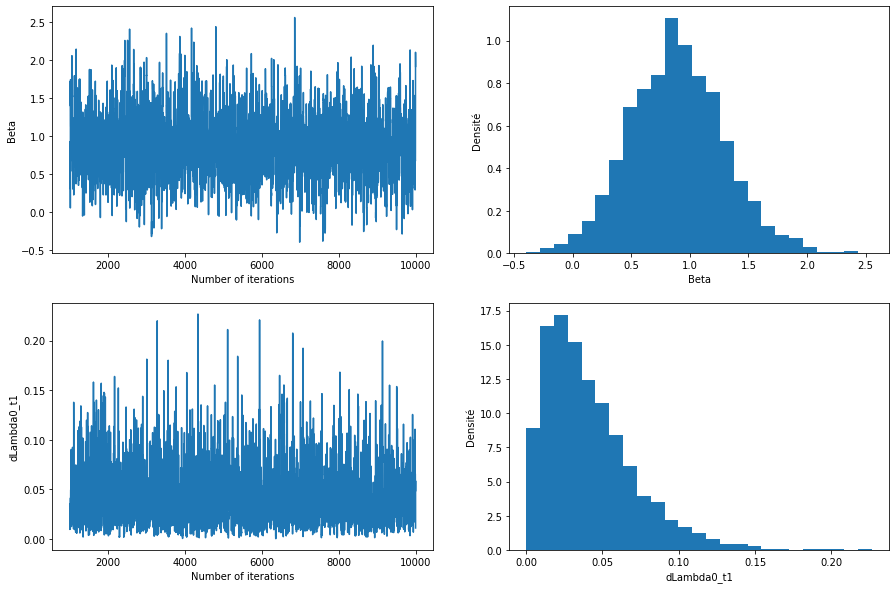

In [7]:
beta = X[burn_period:, 0]
dLambda0_t1 = X[burn_period:, 1]

x = np.arange(burn_period, n)
figure = plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot(x, beta)
plt.xlabel("Number of iterations")
plt.ylabel("Beta")

plt.subplot(2,2,2)
plt.hist(beta, bins = 25, density=True)
plt.xlabel("Beta")
plt.ylabel("Densité")

plt.subplot(2,2,3)
plt.plot(x, dLambda0_t1)
plt.xlabel("Number of iterations")
plt.ylabel("dLambda0_t1")

plt.subplot(2,2,4)
plt.hist(dLambda0_t1, bins = 25, density=True)
plt.xlabel("dLambda0_t1")
plt.ylabel("Densité")

plt.show()

Thus, the Markov chain has good mixing properties.

In [8]:
# Show the results

names = np.array(["beta"] + ['dL0'+str(j) for j in range(1, T+1)]).reshape(-1, 1)
mean = np.mean(X[burn_period:,], axis=0).reshape(-1, 1)
sd = np.sqrt(np.var(X[burn_period:,], axis=0)).reshape(-1, 1)
acc_perc = (np.floor(acc*100)).reshape((-1, 1))

print(np.concatenate((names, acc_perc, mean, sd), axis=1))

[['beta' '46.0' '0.890138584670845' '0.4049183358364596']
 ['dL01' '40.0' '0.041409555534165615' '0.02936040272050297']
 ['dL02' '40.0' '0.042644247329894386' '0.02948622305906688']
 ['dL03' '54.0' '0.020871033404904413' '0.02150807137519712']
 ['dL04' '41.0' '0.0424222758388448' '0.0305977112453745']
 ['dL05' '41.0' '0.04287277424879194' '0.0305940409624158']
 ['dL06' '34.0' '0.06352756415782788' '0.03717302030445398']
 ['dL07' '54.0' '0.02119215449373195' '0.02108822267193142']
 ['dL08' '30.0' '0.08777531636350239' '0.04369305352707965']
 ['dL09' '53.0' '0.021336464326779787' '0.021291337576598766']
 ['dL010' '40.0' '0.04230941878186584' '0.02997363447529206']
 ['dL011' '41.0' '0.042941744241038554' '0.030013280718660537']
 ['dL012' '53.0' '0.02183310515448528' '0.021877327482945394']
 ['dL013' '53.0' '0.02158003824474977' '0.02144239598489354']
 ['dL014' '53.0' '0.021800922304131765' '0.021754316785637544']
 ['dL015' '52.0' '0.021249697035775884' '0.020826457738172814']
 ['dL016' '4

We don't get the same results as OpenBUGS, since $\beta = 0.87$ for us versus $1.54$ for OpenBUGS but we get the same standard deviation (0.4).
Acceptance rates are too big for a high dimensional problem (here dimension = 18 > 2), since we get around 40-50% but we should get around 25%.

## Survival function

Also, one can implement the survival function which is defined as:

$$ S(t) = \mathcal{P}(X>t) =  exp(-exp(\beta z_i) \int_{0}^{t} \lambda_0(u) du)$$
with $z_i = -0.5$ for a treated patient and $z_i = 0.5$ for a placebo patient. The survival function is the probability for a patient to survive beyond time t. 

In [0]:
# Computation of the survival functions

beta = mean[0,0]
dL = mean[1:].flatten()

Streat = np.exp(-np.exp(-beta*0.5)*np.cumsum(dL))
Splacebo = np.exp(-np.exp(beta*0.5)*np.cumsum(dL))

We get the same values for survival functions than OpenBUGS.

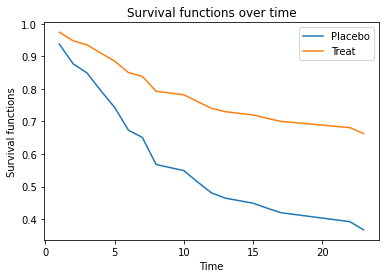

In [10]:
plt.plot(t[:-1], Splacebo, label = "Placebo")
plt.plot(t[:-1], Streat, label = "Treat")
plt.title("Survival functions over time")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Survival functions")
plt.show()

One can notice that a patient under placebo has less chances to survive than a patient under real treatment. Moreover, chances to survive, under placebo and under treat, decrease over time.